# [DRAFT] Large-Scale Non-linear Dynamical System 

This notebook does not perform any becnhmark and simply runs the inference procedure and generates some nice plots for the thesis.

Note: This notebook is a draft, the real experiments are in the `notebooks/` folder

_Author: Dmitry Bagaev_

In [73]:
using DrWatson

In [74]:
@quickactivate "RxInferThesisExperiments"

In [75]:
using RxInferThesisExperiments, RxInfer, StaticArrays, Plots, PGFPlotsX, LaTeXStrings
using LinearAlgebra, StableRNGs, Random, BenchmarkTools, ColorSchemes, Dates

In [76]:
# For the thesis I use the `pgfplotsx` backend of the `Plots`, since it generates high-quiality plots
# But it is reallyyy slow, if some wants to generate plots faster uncoment the `gr()` line
# pgfplotsx()

# Use fast plotting backend
gr()

Plots.GRBackend()

## Double pendulum environment

In [77]:
# Create default environment with default parameters
const environment = DoublePendulum()

DoublePendulum()

In [78]:
# Define state-transition function, uses RK4 method internally, see the `src/` folder
f(state) = state_transition(environment)(state)

f (generic function with 1 method)

In [79]:
# Include the model specification
include(srcdir("models", "rxinfer", "double_pendulum.jl"));

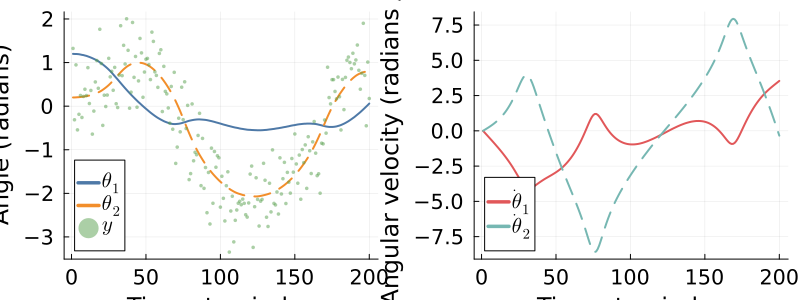

In [80]:
# For plotting purposes I only generate 250 points
T = 200
seed = 43
rng = StableRNG(seed)

states, observations = rand(rng, environment, T; random_start = false);

# `plotting`range
prange = firstindex(states):lastindex(states)
colors = ColorSchemes.tableau_10

# Some default settings for plotting
pfontsettings = (
    titlefontsize=18,
    guidefontsize=16,
    tickfontsize=14,
    legendfontsize=14,
    legend = :bottomleft,
    size = (400, 300)
)

p1 = plot(xlabel = "Time step index", ylabel = "Angle (radians)"; pfontsettings...)
p1 = plot!(prange, getindex.(states, 1)[prange], color = colors[1], linewidth = 2, label = L"\theta_1")
p1 = plot!(p1, prange, getindex.(states, 2)[prange], color = colors[2], linewidth = 2, label = L"\theta_2", style = :dash)
p1 = scatter!(p1, prange, observations[prange], ms = 2, msw = 0, color = colors[5], alpha = 0.5, label = L"y")

p2 = plot(xlabel = "Time step index", ylabel = "Angular velocity (radians / s)"; pfontsettings...)
p2 = plot!(p2, prange, getindex.(states, 3)[prange], color = colors[3], linewidth = 2, label = L"\dot{\theta}_1")
p2 = plot!(p2, prange, getindex.(states, 4)[prange], color = colors[4], linewidth = 2, label = L"\dot{\theta}_2", style = :dash)

plot(p1, p2, layout = @layout([ a b ]), size = (800, 300))

In [81]:
# First invoke slow as usual, but we do not perform benchmarks here so it does not really matter
# We perform a small benchmark below, for that we need to wrap the `inference` call in a separate function
function run_inference(T, fstate, observations)
    return inference(
        model = double_pendulum(T, fstate),
        data = (y = observations, ),
        meta = double_pendulum_meta(),
        constraints = double_pendulum_constraints(),
        returnvars = (s = KeepLast(), ),
        iterations = 4,
        initmarginals = (σ = Gamma(0.001, 100.0), ),
        options = (limit_stack_depth = 500, )
    )
end

run_inference (generic function with 3 methods)

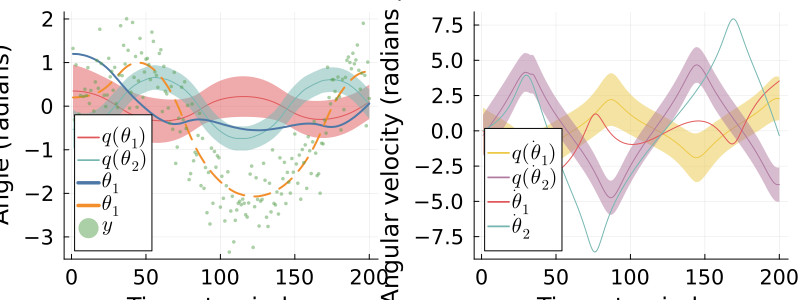

In [82]:
em = mean.(results.posteriors[:s])
ev = std.(results.posteriors[:s])
p1 = plot(xlabel = "Time step index", ylabel = "Angle (radians)"; pfontsettings...)

plot!(prange, getindex.(em, 1)[prange], color = colors[3], ribbon = 3getindex.(ev, 1, 1), label = L"q(\theta_1)")
plot!(prange, getindex.(em, 2)[prange], color = colors[4], ribbon = 3getindex.(ev, 2, 2), label = L"q(\theta_2)")
plot!(prange, getindex.(states, 1)[prange], label = L"\theta_1", color = colors[1], linewidth = 2,)
plot!(prange, getindex.(states, 2)[prange], label = L"\theta_1", color = colors[2], linewidth = 2, style = :dash)
scatter!(prange, getindex.(observations, 1)[prange], ms = 2, msw = 0, alpha = 0.5, color = colors[5], label = L"y")

p2 = plot(size=(800, 300), xlabel = "Time step index", ylabel = "Angular velocity (radians / s)"; pfontsettings...)
plot!(prange, getindex.(em, 3)[prange], ribbon = 3getindex.(ev, 3, 3), color = colors[6], label = L"q(\dot{\theta}_1)")
plot!(prange, getindex.(em, 4)[prange], ribbon = 3getindex.(ev, 4, 4), color = colors[7], label = L"q(\dot{\theta}_2)")
plot!(prange, getindex.(states, 3)[prange], color = colors[3], label = L"\dot{\theta}_1")
plot!(prange, getindex.(states, 4)[prange], color = colors[4], label = L"\dot{\theta}_2")

plot(p1, p2, size = (800, 300), layout = @layout([ a b ]))